In [16]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime, os
import open_cp.predictors
import open_cp.kernels
import open_cp.seppexp
import open_cp.naive
import open_cp.evaluation
import open_cp.logger
open_cp.logger.log_to_true_stdout()

In [2]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [3]:
def load(side, start, end):
    geo = open_cp.sources.chicago.get_side(side)
    grid = open_cp.data.Grid(150, 150, 0, 0)
    grid = open_cp.geometry.mask_grid_by_intersection(geo, grid)
    mask = (all_points.timestamps >= start) & (all_points.timestamps < end)
    points = all_points[mask]
    points = open_cp.geometry.intersect_timed_points(points, geo)
    return grid, points, geo

grid, points, geo = load("South", np.datetime64("2010-01-01"), np.datetime64("2010-09-01"))

In [4]:
trainer = open_cp.seppexp.SEPPTrainer(grid=grid)
trainer.data = points
predictor = trainer.train(cutoff_time=np.datetime64("2011-09-01"), iterations=50)

In [5]:
back = predictor.background_prediction()
predictor.data = points
pred = predictor.predict(np.datetime64("2011-09-01T12:00"))
predictor.theta, predictor.omega * 60 * 24

(0.019714080168027698, 22.759254795338816)

In [6]:
npredictor = open_cp.naive.CountingGridKernel(grid.xsize, region=grid.region())
npredictor.data = points
naive = npredictor.predict()
naive.mask_with(grid)
naive = naive.renormalise()

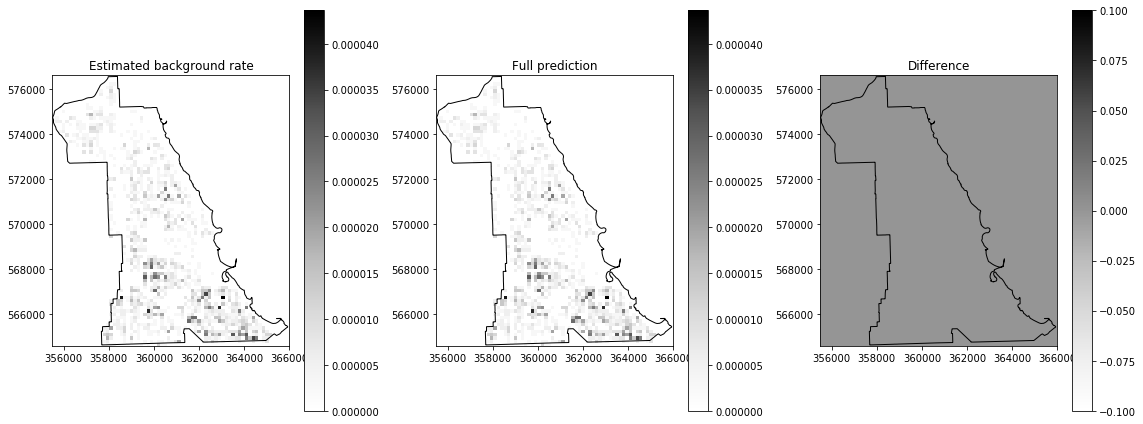

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(16,6))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)

mappable = axes[0].pcolor(*back.mesh_data(), back.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Estimated background rate")

mappable = axes[1].pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("Full prediction")

mat = pred.intensity_matrix - back.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

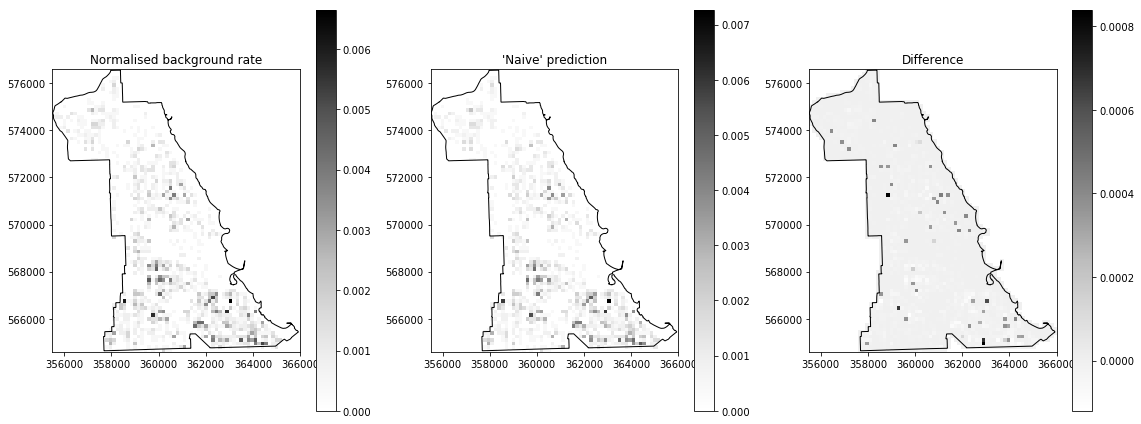

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(16,6))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)

nback = back.renormalise()
mappable = axes[0].pcolor(*nback.mesh_data(), nback.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[0])
axes[0].set_title("Normalised background rate")

mappable = axes[1].pcolor(*naive.mesh_data(), naive.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[1])
axes[1].set_title("'Naive' prediction")

mat = naive.intensity_matrix - nback.intensity_matrix
mappable = axes[2].pcolor(*pred.mesh_data(), mat, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=axes[2])
axes[2].set_title("Difference")

fig.tight_layout()

# Compare hit rates

Cannot be distinguished.

In [13]:
class SeppExpProvider(open_cp.evaluation.StandardPredictionProvider):
    def give_prediction(self, grid, points, time):
        trainer = open_cp.seppexp.SEPPTrainer(grid=grid)
        trainer.data = points
        predictor = trainer.train(cutoff_time=time, iterations=50)
        return predictor.background_prediction()

In [9]:
grid, points, geo = load("South", np.datetime64("2010-01-01"), np.datetime64("2011-01-01"))

In [10]:
provider = open_cp.evaluation.NaiveProvider(points, grid)
evaluator = open_cp.evaluation.HitRateEvaluator(provider)
evaluator.data = points
time_range = evaluator.time_range(datetime.datetime(2010,9,1),
        datetime.datetime(2010,12,31), datetime.timedelta(days=1))
result = evaluator.run(time_range, range(1,100))

In [14]:
provider = SeppExpProvider(points, grid)
evaluator = open_cp.evaluation.HitRateEvaluator(provider)
evaluator.data = points
time_range = evaluator.time_range(datetime.datetime(2010,9,1),
        datetime.datetime(2010,12,31), datetime.timedelta(days=1))
result1 = evaluator.run(time_range, range(1,100))

In [17]:
import pandas as pd

In [22]:
frame = pd.DataFrame(result.rates).T.describe().T
frame.head()

,count,mean,std,min,25%,50%,75%,max
1,122.0,0.079611,0.104997,0.0,0.000000,0.054094,0.121528,0.500
2,122.0,0.146727,0.121478,0.0,0.072802,0.125000,0.222222,0.500
3,122.0,0.194759,0.142200,0.0,0.100000,0.184659,0.282468,0.625
4,122.0,0.230596,0.141392,0.0,0.119485,0.222222,0.328125,0.625
5,122.0,0.265154,0.154176,0.0,0.166667,0.250000,0.356061,0.750


In [23]:
frame1 = pd.DataFrame(result1.rates).T.describe().T
frame1.head()

,count,mean,std,min,25%,50%,75%,max
1,122.0,0.081683,0.108108,0.0,0.000000,0.057190,0.125000,0.500
2,122.0,0.146322,0.126943,0.0,0.060784,0.114379,0.222222,0.500
3,122.0,0.198521,0.144029,0.0,0.090909,0.195238,0.285714,0.625
4,122.0,0.232531,0.142054,0.0,0.117647,0.235294,0.328125,0.625
5,122.0,0.269266,0.154967,0.0,0.157051,0.281746,0.367225,0.750


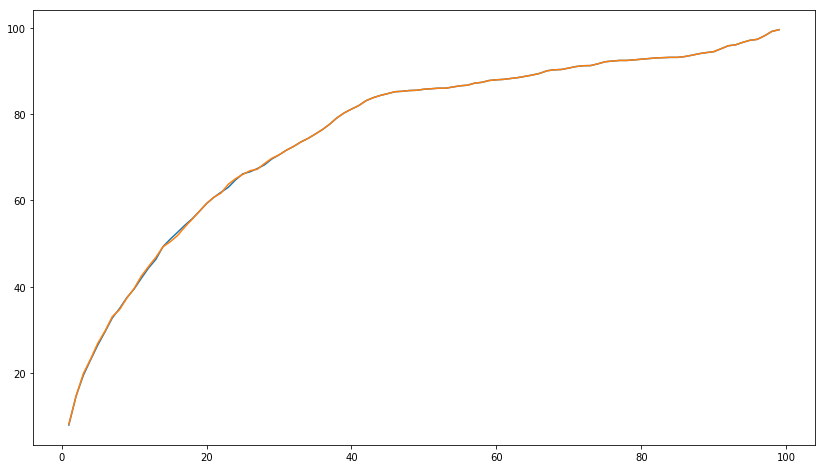

In [26]:
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(frame["mean"]*100, label="naive")
ax.plot(frame1["mean"]*100, label="sepp")

# With cutoff


In [21]:
import sepp.sepp_grid

class SeppExpProvider(open_cp.evaluation.StandardPredictionProvider):
    def give_prediction(self, grid, points, time):
        trainer = sepp.sepp_grid.ExpDecayTrainerWithCutoff(grid, cutoff=0.5)
        trainer.data = points # Add noise??
        model = trainer.train(time, iterations=50)
        return trainer.prediction_from_background(model)

In [10]:
grid, points, geo = load("South", np.datetime64("2010-01-01"), np.datetime64("2011-01-01"))

In [11]:
provider = open_cp.evaluation.NaiveProvider(points, grid)
evaluator = open_cp.evaluation.HitRateEvaluator(provider)
evaluator.data = points
time_range = evaluator.time_range(datetime.datetime(2010,9,1),
        datetime.datetime(2010,12,31), datetime.timedelta(days=1))
result = evaluator.run(time_range, range(1,100))

In [22]:
provider = SeppExpProvider(points, grid)
evaluator = open_cp.evaluation.HitRateEvaluator(provider)
evaluator.data = points
time_range = evaluator.time_range(datetime.datetime(2010,9,1),
        datetime.datetime(2010,12,31), datetime.timedelta(days=1))
result1 = evaluator.run(time_range, range(1,100))

In [25]:
import pandas as pd
frame = pd.DataFrame(result.rates).T.describe().T
frame1 = pd.DataFrame(result1.rates).T.describe().T

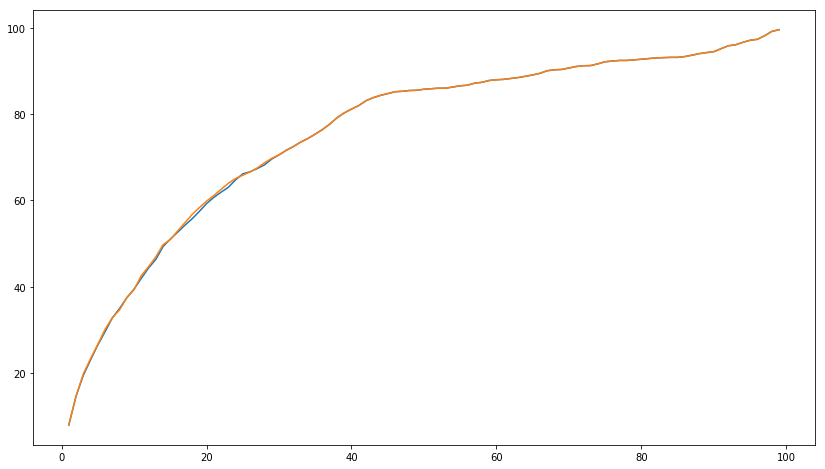

In [26]:
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(frame["mean"]*100, label="naive")
ax.plot(frame1["mean"]*100, label="sepp")